## Import

In [ ]:
!apt-get install -y -qq glpk-utils
!pip install -qqq chama wntr pyswarms
!pip install pyswarms

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import chama
import wntr
import random
import time
import math
import pyswarms as ps
from pyswarms.discrete import BinaryPSO
from scipy.special import softmax
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
from numpy.random import choice

#INITIALIZE

##Visual Network

In [3]:
def read_network(path):
    water_network = wntr.network.WaterNetworkModel(path)
    print(len(water_network.junction_name_list))
    print(water_network.describe(level=0) )
    wntr.graphics.plot_network(water_network , node_attribute='elevation',  node_colorbar_label='Elevation (m)')
    return water_network.describe(level=0)

In [7]:
!ls

rensors-distribution  report.log  sample_data


2022-04-29 01:51:58,360 - wntr.epanet.io - WARNING - Unknown report parameter: MESSAGES
2022-04-29 01:51:58,371 - wntr.epanet.io - WARNING - Unknown report parameter: State


9
{'Nodes': 11, 'Links': 13, 'Patterns': 1, 'Curves': 1, 'Sources': 0, 'Controls': 2}


{'Controls': 2,
 'Curves': 1,
 'Links': 13,
 'Nodes': 11,
 'Patterns': 1,
 'Sources': 0}

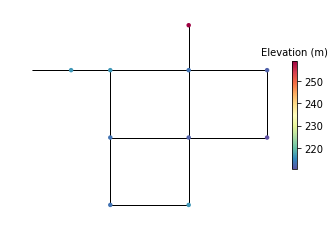

In [8]:
path = "rensors-distribution/data/Net1_temp.inp"
read_network(path)

##Read File

In [9]:
def input_network(path):
    time_s = time.time()
    water_network = wntr.network.WaterNetworkModel(path)
    # Run trace simulations (one from each junction) and extract data needed for 
    # sensor placement optimization. You can run this step once, save the data to a 
    # file, and reload the file for sensor placement
    scenario_names = water_network.node_name_list
    sim = wntr.sim.EpanetSimulator(water_network)
    sim.run_sim(save_hyd = True)
    water_network.options.quality.parameter = 'TRACE'
    signal = pd.DataFrame()
    for inj_node in scenario_names:
        water_network.options.quality.trace_node = inj_node
        sim_results = sim.run_sim(use_hyd = True)
        trace = sim_results.node['quality']
        trace = trace.stack()
        trace = trace.reset_index()
        trace.columns = ['T', 'Node', inj_node]
        signal = signal.combine_first(trace)
    # Define feasible sensors using location, sample times, and detection threshold

    sensor_names = water_network.node_name_list
    sample_times = np.arange(0, water_network.options.time.duration, water_network.options.time.hydraulic_timestep)
    undetected_impact = sample_times.max()*1.5
    node_to_id = dict(zip(scenario_names, np.arange(len(scenario_names))))
    id_to_node = dict(zip(np.arange(len(scenario_names)), scenario_names))
    n_scenarios = len(scenario_names)

    df_dummy = pd.DataFrame({'Scenario': scenario_names,
                            'Sensor': 'DUMMY_SENSOR_UNDETECTED',
                            'Impact': undetected_impact})
    threshold = 1e-5
    # threshold = 20
    sensors = {}
    for location in sensor_names:
        position = chama.sensors.Stationary(location)
        detector = chama.sensors.Point(threshold, sample_times)
        stationary_pt_sensor = chama.sensors.Sensor(position, detector)
        sensors[location] = stationary_pt_sensor

    # Extract minimum detection time for each scenario-sensor pair
    det_times = chama.impact.extract_detection_times(signal, sensors)
    det_time_stats = chama.impact.detection_time_stats(det_times)
    min_det_time = det_time_stats[['Scenario','Sensor','Min']]
    min_det_time.rename(columns = {'Min':'Impact'}, inplace = True)

    scenario_characteristics = pd.DataFrame({'Scenario': scenario_names,
                                        'Undetected Impact': undetected_impact})
    sensor_characteristics = pd.DataFrame({'Sensor': sensor_names,'Cost': 1})

    cols = min_det_time.loc[:, "Scenario"].apply(node_to_id.get).values
    rows = min_det_time.loc[:, "Sensor"].apply(node_to_id.get).values
    values = min_det_time.loc[:, "Impact"]

    dt = np.full((rows.max() + 1, cols.max() + 1), undetected_impact)
    dt[rows, cols] = values
    read_time = time.time()-time_s
    return (read_time, water_network, min_det_time, dt, node_to_id, n_scenarios, sensor_characteristics, scenario_characteristics)

##Chama

In [10]:
def run_by_chama(min_det_time, sensor_characteristics, scenario_characteristics, limit_sensors):
  time_s = time.time()
  impactform = chama.optimize.ImpactFormulation()
  result = impactform.solve(min_det_time, sensor_characteristics, scenario_characteristics, limit_sensors)
  wntr.graphics.plot_network(water_network, node_attribute=result['Sensors'])
  chama_time = time.time()-time_s
  return result, chama_time

##GA

In [11]:
log_node_iter = []
log_population = []

class Population:       # quần thể
    def __init__(self, water_network, size_of_population, num_available_sensors, method, list_individuals) -> None:
        self.water_network = water_network
        self.scenario_names = water_network.node_name_list
        self.sensor_names = water_network.junction_name_list
        self.num_sensors = len(self.sensor_names)
        self.size_of_population = size_of_population
        self.num_available_sensors = num_available_sensors
        self.method = method
        self.list_individuals = list_individuals
        self.best_individual = None
        self.best_sensors = None
        self.score = 0
        self.parents = []


    def choosed_sensors(self, individual):      # from idx -> list sensor
        try:
            _choosed = [self.sensor_names[i] for i in individual]
        except:
            print(self.sensor_names[i])
            print(individual)
            input()
        return _choosed

    # đột biến
    def mutate(self, individual):
        def _mutate():
            new_sensor = random.choice(range(self.num_sensors))
            while new_sensor in individual:
                new_sensor = random.choice(range(self.num_sensors))
            idx = np.random.randint(len(individual))
            individual[idx] = new_sensor
            individual.sort()
            return individual

        _new = _mutate()
        return _new

    def evaluate(self):
        times = np.asarray([ self.method(min_det_time, self.choosed_sensors(individual)) for individual in self.list_individuals])
        self.score = np.min(times)
       
        self.best_individual = self.list_individuals[times.tolist().index(self.score)]
        
        self.best_sensors = self.choosed_sensors(self.best_individual)
        log_node_iter.append(self.best_sensors)
        log_population.append(self.list_individuals)
        self.parents.append(self.best_individual)
        if False in (times[0] == times):
            distances = np.max(times) - times
        return times / np.sum(times)


    def select(self, num_parents):
        time_s = time.time()
        fit = self.evaluate()
#         print("Time eval: ", time.time() - time_s)
        while len(self.parents) < num_parents:
            idx = np.random.randint(0, self.size_of_population)
            if fit[idx] > np.random.uniform(0, 1/self.size_of_population, size=(1,))[0]:
                self.parents.append(self.list_individuals[idx])

        self.parents = np.asarray(self.parents)

    def crossover(self, p_cross=0.75):
        def cross():
            id1, id2 = np.random.choice(len(self.parents), size=2, replace=False)
            parent1, parent2 = self.parents[id1], self.parents[id2]
           # print(parent1)
           # print(parent2)
            gen_set=set(np.concatenate((parent1, parent2)))
            gen_set=list(gen_set)
            child = choice(gen_set, size=(self.num_available_sensors,), replace=False)
            child.sort()
            #print(child)
            return child
            
        children = []
        count = len(self.parents)
        for _ in range(self.size_of_population):
            if np.random.rand() > p_cross:
                _tmp = random.choice(self.parents)
                children.append(_tmp)
                
            else:
                child = cross()
                children.append(child)

        # print(children)
        return children

    def next_population(self, p_cross=0.75, p_mutate=0.1):
        _best_individual = self.best_individual
        
        _next = []
        children = self.crossover(p_cross)
        for child in children:
            # print(child.selected_sensors)
            if np.random.rand() < p_mutate:
                # print("mutate")
                child_mutate = self.mutate(child)
                # print(child_mutate)
                if self.method(min_det_time, self.choosed_sensors(_best_individual))  >  self.method(min_det_time, self.choosed_sensors(child_mutate)):
                    _next.append(child_mutate)
                else:
                    _next.append(_best_individual)
                    _best_individual = child_mutate

            else:
                # print("un_mutate")
                # print(child)
                if self.method(min_det_time, self.choosed_sensors(_best_individual))  >  self.method(min_det_time, self.choosed_sensors(child)):
                    _next.append(child)
                else:
                    _next.append(_best_individual)
                    _best_individual = child

        if(self.best_individual not in _next):
            _next[-1] = self.best_individual
        return _next


def init_population(water_network, size_of_population, num_available_sensors, method):
    # khởi tạo 1 cá thể ngẫu nhiên
    def init_individual(sensor_names, num_available_sensors):
        
        individual = np.random.choice(range(len(sensor_names)), size=num_available_sensors, replace=False)
        individual.sort()
        return individual

    sensor_names = water_network.junction_name_list
    population = []
    for id in range(0, size_of_population):
        population.append( init_individual(sensor_names, num_available_sensors) )
    return Population(water_network, size_of_population, num_available_sensors, method, population )

In [12]:
def detection_time_GA(impact, selected_sensors):
    sensors_id = [node_to_id.get(s) for s in selected_sensors]
    return dt[sensors_id, :].min(axis=0).mean()

In [13]:
def genetic_algorithm(
    water_network,
    size_of_population,
    num_available_sensors,
    method,
    selectivity=0.15,
    n_iter=100,
    p_cross=0.75,
    p_mut=0.1,
    print_interval=100,
    return_history=False,
    verbose=False,
):
    t1 = time.time()
    pop = init_population(water_network, size_of_population, num_available_sensors, method)
    best_sensors = pop.best_sensors
    score = float("inf")
    history = []
    for i in range(n_iter):
        pop.select(size_of_population * selectivity)
        # print(pop.parents)
        history.append(pop.score)
        # if verbose:
        #     print(f"Generation {i}: {pop.score}")
        # elif i % print_interval == 0:
        #     print(f"Generation {i}: {pop.score}")
        if pop.score < score:
            best_sensors = pop.best_sensors
            score = pop.score
        
        children = pop.next_population(p_cross, p_mut)
        
        pop = Population(water_network, size_of_population, num_available_sensors, method, children)
    if return_history:
        return best_sensors, score, history
    return best_sensors, score

In [ ]:
def run_ga():
  log_node_iter = []
  log_population = []

  time_s = time.time()
  best, score, history = genetic_algorithm(
      water_network = water_network,
      size_of_population=n_scenarios*20,
      num_available_sensors=5,
      method=detection_time_GA,
      n_iter=100,
      selectivity=0.15,
      p_cross=0.75,
      p_mut=0.1,
      print_interval=5,
      verbose=True,
      return_history=True
  )
  GA_time = time.time() - time_s
  plt.plot(range(len(history)), history, color="blue")
  wntr.graphics.plot_network(water_network, node_attribute=best)
  plt.show()

  return GA_time, score, best



##PSO

In [ ]:
def run_pso():
  options = {'c1': 0.5, 'c2': 0.5, 'w':0.9}
  bounds = (-2000. * np.ones(n_scenarios), 2000. * np.ones(n_scenarios))
  time_s = time.time()
  # Call instance of PSO
  optimizer = ps.single.GlobalBestPSO(n_particles = int(n_scenarios*2), dimensions=n_scenarios, options=options, bounds=bounds)

  # Objective function
  def detection_time_PSO(swarms):
      sensor_ids = np.argpartition(swarms, -5, axis=1)[:, -5:]  # (n_particles, n_sensors)
      output = dt[sensor_ids].min(axis=1).mean(axis=1)
      return output

  best_cost, best_pos = optimizer.optimize(detection_time_PSO, iters=1000)
  PSO_time = time.time() - time_s
  plot_cost_history(optimizer.cost_history)
  plt.show()
  # position
  best_pos = np.argpartition(best_pos, -5)[-5:]
  PSO_pos = [water_network.node_name_list[a] for a in best_pos]
  # draw
  wntr.graphics.plot_network(water_network, node_attribute=PSO_pos)
  return  PSO_time, best_cost, PSO_pos
  


#RUN

##NET3

92
{'Nodes': 97, 'Links': 119, 'Patterns': 5, 'Curves': 2, 'Sources': 0, 'Controls': 18}


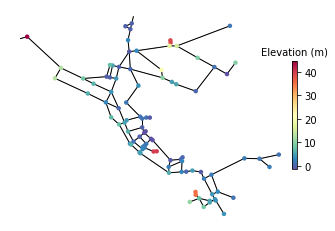

In [ ]:
path = "inp/Net3.inp"
net_info = read_network(path)

In [ ]:
read_time, water_network, min_det_time, dt, node_to_id, n_scenarios, sensor_characteristics, scenario_characteristics = input_network(path)
print('read time', read_time)

2022-04-28 23:15:22,532 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


read time 20.83464217185974


C:\Users\X1 carbon\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
limit_sensors = 5
chama_result, chama_time = run_by_chama(min_det_time, sensor_characteristics, scenario_characteristics, limit_sensors)
print('Chama time',chama_time)
print('Chama result', chama_result['Objective'])

In [ ]:
GA_time, GA_score, GA_best = run_ga()
print('GA time',GA_time)
print('GA result', GA_score)

In [ ]:
PSO_time, PSO_score, PSO_pos = run_pso()
print('PSO time',PSO_time)
print('PSO result', PSO_score)

In [ ]:
data = np.array([[path, limit_sensors, net_info['Nodes'], net_info['Links'],
                  read_time, chama_time, chama_result['Objective'],
                  GA_time, GA_score, PSO_time, PSO_score]])

In [ ]:
df = pd.DataFrame(data, columns=['Net', 'sensors', 'Nodes', 'Links','read_time', 'chama_time', 'chama_score',
                                 'GA_time', 'GA_score', 'PSO_time', 'PSO_score'])

In [ ]:
df

##Example_1

9
{'Nodes': 11, 'Links': 13, 'Patterns': 1, 'Curves': 1, 'Sources': 0, 'Controls': 2}


C:\Users\X1 carbon\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
2022-04-28 23:20:12,238 - pyomo.solvers - WARNING - Could not locate the 'glpsol' executable, which is required for solver 'glpk'


ApplicationError: No executable found for solver 'glpk'

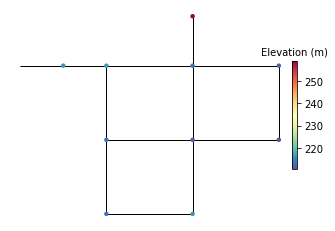

In [ ]:
path = "inp/Net1.inp"
net_info = read_network(path)
read_time, water_network, min_det_time, dt, node_to_id, n_scenarios, sensor_characteristics, scenario_characteristics = input_network(path)
limit_sensors = 5
chama_result, chama_time = run_by_chama(min_det_time, sensor_characteristics, scenario_characteristics, limit_sensors)
GA_time, GA_score, GA_best = run_ga()
PSO_time, PSO_score, PSO_pos = run_pso()
new_data = np.array([[path.replace('networks/',''), limit_sensors, net_info['Nodes'], net_info['Links'],
                  read_time, chama_time, chama_result['Objective'],
                  GA_time, GA_score, PSO_time, PSO_score]])
data = np.concatenate((data, new_data), axis=0)

In [ ]:
df = pd.DataFrame(data, columns=['Net', 'sensors', 'Nodes', 'Links','read_time', 'chama_time', 'chama_score',
                                 'GA_time', 'GA_score', 'PSO_time', 'PSO_score'])

In [ ]:
df

,Net,sensors,Nodes,Links,read_time,chama_time,chama_score,GA_time,GA_score,PSO_time,PSO_score
0,Net3.inp,5,97,119,19.40468692779541,1.4956820011138916,68548.45360824742,20.529613971710205,86214.43298969071,3.510399341583252,72705.15463917526
1,Example_1.inp,5,130,180,70.99948024749756,1.6794674396514893,102565.38461538462,29.32252025604248,119263.84615384616,5.224121809005737,105438.46153846153
2,Example_1.inp,5,130,180,71.30011057853699,1.7239351272583008,102565.38461538462,28.257431030273438,103915.38461538461,4.965407609939575,116536.15384615384


##ky5_Jolly2013

423
{'Nodes': 430, 'Links': 507, 'Patterns': 3, 'Curves': 0, 'Sources': 0, 'Controls': 8}


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


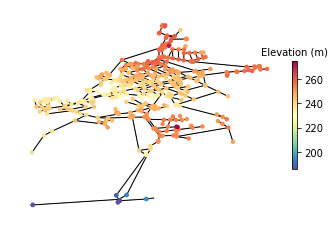

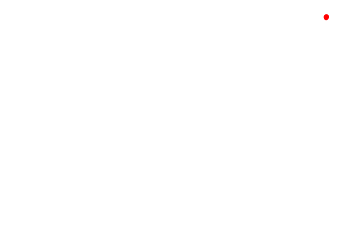

2022-04-10 12:05:07,110 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=5.08e+4
2022-04-10 12:05:44,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 50826.976744186046, best pos: [-4.283e+02  2.826e+02 -1.458e+02 -9.011e+01 -3.430e+02  4.805e+02 -7.345e+02 -1.241e+03 -1.236e+03 -7.062e+02  5.574e+02 -2.119e+02  6.261e+01  6.275e+01  3.297e+02  4.374e+02 -1.237e+03  3.504e+02 -3.085e+02 -3.658e+02 -9.526e+00  3.758e+02 -5.444e+02 -4.417e+02 -1.190e+02  1.974e+01 -1.457e+02
 -4.600e+02 -5.453e+02  3.897e+02 -3.753e+02  5.725e+01 -1.346e+02 -2.959e+02 -2.481e+02  7.079e+01 -2.512e+02  2.135e+02 -4.044e+02  3.374e+02  1.477e+02 -1.001e+03 -7.400e+02  1.379e+03  7.103e+02  6.677e+02  1.114e+02  5.044e+02 -1.282e+02 -5.481e+02  1.328e+02 -3.831e+02 -4.908e+01 -9.652e+02
 -5.254e+02  1.720e+02  1.141e+03 -5.426e+02 -5.055e+02  1.140e+02 -2.390e+02 -5

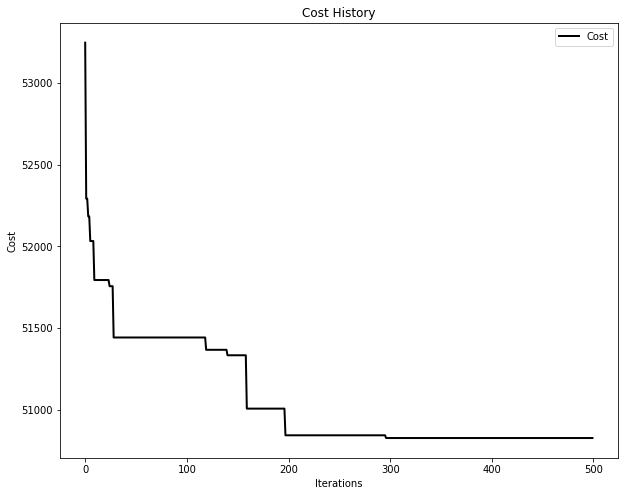

,Net,sensors,Nodes,Links,read_time,chama_time,chama_score,GA_time,GA_score,PSO_time,PSO_score
0,Net3.inp,5,97,119,19.40468692779541,1.4956820011138916,68548.45360824742,20.529613971710205,86214.43298969071,3.510399341583252,72705.15463917526
1,Example_1.inp,5,130,180,70.99948024749756,1.6794674396514893,102565.38461538462,29.32252025604248,119263.84615384616,5.224121809005737,105438.46153846153
2,Example_1.inp,5,130,180,71.30011057853699,1.7239351272583008,102565.38461538462,28.257431030273438,103915.38461538461,4.965407609939575,116536.15384615384
3,ky5_Jolly2013.inp,5,430,507,176.7266490459442,150.40282225608826,49847.441860465115,132.47464632987976,51053.023255813954,36.97239804267883,50826.976744186046


In [ ]:
path = "networks/ky5_Jolly2013.inp"
net_info = read_network(path)
read_time, water_network, min_det_time, dt, node_to_id, n_scenarios, sensor_characteristics, scenario_characteristics = input_network(path)
limit_sensors = 5
chama_result, chama_time = run_by_chama(min_det_time, sensor_characteristics, scenario_characteristics, limit_sensors)
GA_time, GA_score, GA_best = run_ga()
PSO_time, PSO_score, PSO_pos = run_pso()
new_data = np.array([[path.replace('networks/',''), limit_sensors, net_info['Nodes'], net_info['Links'],
                  read_time, chama_time, chama_result['Objective'],
                  GA_time, GA_score, PSO_time, PSO_score]])
data = np.concatenate((data, new_data), axis=0)
df = pd.DataFrame(data, columns=['Net', 'sensors', 'Nodes', 'Links','read_time', 'chama_time', 'chama_score',
                                 'GA_time', 'GA_score', 'PSO_time', 'PSO_score'])
df

##Net6


In [ ]:
wn = wntr.network.WaterNetworkModel('networks/Net6.inp') 
skel_wn = wntr.morph.skeletonize(wn, 12*0.0254)


2022-04-10 13:13:01,498 - wntr.morph.skel - INFO - Branch trim: JUNCTION-12['JUNCTION-11']
2022-04-10 13:13:01,504 - wntr.morph.skel - INFO - Branch trim: JUNCTION-16['JUNCTION-15']
2022-04-10 13:13:01,508 - wntr.morph.skel - INFO - Branch trim: JUNCTION-20['JUNCTION-19']
2022-04-10 13:13:01,512 - wntr.morph.skel - INFO - Branch trim: JUNCTION-38['JUNCTION-37']
2022-04-10 13:13:01,517 - wntr.morph.skel - INFO - Branch trim: JUNCTION-39['JUNCTION-37']
2022-04-10 13:13:01,519 - wntr.morph.skel - INFO - Branch trim: JUNCTION-40['JUNCTION-35']
2022-04-10 13:13:01,525 - wntr.morph.skel - INFO - Branch trim: JUNCTION-41['JUNCTION-14']
2022-04-10 13:13:01,527 - wntr.morph.skel - INFO - Branch trim: JUNCTION-45['JUNCTION-42']
2022-04-10 13:13:01,529 - wntr.morph.skel - INFO - Branch trim: JUNCTION-53['JUNCTION-52']
2022-04-10 13:13:01,531 - wntr.morph.skel - INFO - Branch trim: JUNCTION-74['JUNCTION-73']
2022-04-10 13:13:01,533 - wntr.morph.skel - INFO - Branch trim: JUNCTION-75['JUNCTION-70']

In [ ]:
path = "networks/Net6.inp"
net_info = read_network(path)
read_time, water_network, min_det_time, dt, node_to_id, n_scenarios, sensor_characteristics, scenario_characteristics = input_network(path)
limit_sensors = 5
chama_result, chama_time = run_by_chama(min_det_time, sensor_characteristics, scenario_characteristics, limit_sensors)
GA_time, GA_score, GA_best = run_ga()
PSO_time, PSO_score, PSO_pos = run_pso()
new_data = np.array([[path.replace('networks/',''), limit_sensors, net_info['Nodes'], net_info['Links'],
                  read_time, chama_time, chama_result['Objective'],
                  GA_time, GA_score, PSO_time, PSO_score]])
data = np.concatenate((data, new_data), axis=0)
df = pd.DataFrame(data, columns=['Net', 'sensors', 'Nodes', 'Links','read_time', 'chama_time', 'chama_score',
                                 'GA_time', 'GA_score', 'PSO_time', 'PSO_score'])
df

3323
{'Nodes': 3356, 'Links': 3892, 'Patterns': 3, 'Curves': 60, 'Sources': 0, 'Controls': 124}


2022-04-10 12:07:15,936 - wntr.epanet.toolkit - ERROR - EPANET error: 4
2022-04-10 12:07:21,123 - wntr.epanet.io - WARNING - Warnings were issued during simulation


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fb91d90b3b0> (for post_execute):


KeyboardInterrupt: ignored

##Tnet3



In [ ]:
path = "networks/Tnet3.inp"
net_info = read_network(path)
read_time, water_network, min_det_time, dt, node_to_id, n_scenarios, sensor_characteristics, scenario_characteristics = input_network(path)
limit_sensors = 5
chama_result, chama_time = run_by_chama(min_det_time, sensor_characteristics, scenario_characteristics, limit_sensors)
GA_time, GA_score, GA_best = run_ga()
PSO_time, PSO_score, PSO_pos = run_pso()
new_data = np.array([[path.replace('networks/',''), limit_sensors, net_info['Nodes'], net_info['Links'],
                  read_time, chama_time, chama_result['Objective'],
                  GA_time, GA_score, PSO_time, PSO_score]])
data = np.concatenate((data, new_data), axis=0)
df = pd.DataFrame(data, columns=['Net', 'sensors', 'Nodes', 'Links','read_time', 'chama_time', 'chama_score',
                                 'GA_time', 'GA_score', 'PSO_time', 'PSO_score'])
df

#test

In [ ]:
cd /content/drive/MyDrive/Data_WN/inp

/content/drive/MyDrive/Data_WN/inp


1121
{'Nodes': 1154, 'Links': 1610, 'Patterns': 3, 'Curves': 60, 'Sources': 0, 'Controls': 124}


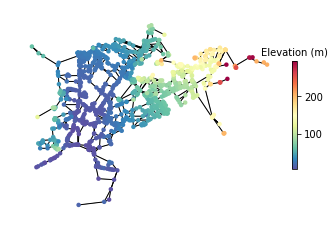

In [ ]:
path = "filename.inp"
net_info = read_network(path)

In [ ]:
read_time, water_network, min_det_time, dt, node_to_id, n_scenarios, sensor_characteristics, scenario_characteristics = input_network(path)
print('read time', read_time)

2022-04-11 03:04:51,284 - wntr.epanet.toolkit - ERROR - EPANET error: 4
2022-04-11 03:04:53,858 - wntr.epanet.io - WARNING - Warnings were issued during simulation
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


read time 5997.768168210983


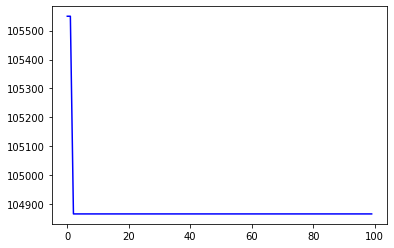

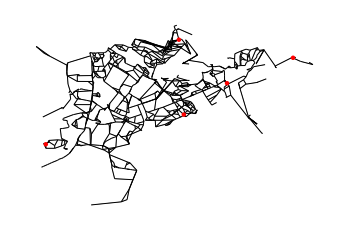

GA time 452.69219732284546
GA result 104866.37781629116


In [ ]:
GA_time, GA_score, GA_best = run_ga()
print('GA time',GA_time)
print('GA result', GA_score)

In [ ]:
PSO_time, PSO_score, PSO_pos = run_pso()
print('PSO time',PSO_time)
print('PSO result', PSO_score)

2022-04-11 04:53:54,362 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:  24%|██▎       |236/1000, best_cost=9.69e+4

In [ ]:
limit_sensors = 5
chama_result, chama_time = run_by_chama(min_det_time, sensor_characteristics, scenario_characteristics, limit_sensors)
print('Chama time',chama_time)
print('Chama result', chama_result['Objective'])

In [ ]:
data = np.array([[path, limit_sensors, net_info['Nodes'], net_info['Links'],
                  read_time, chama_time, chama_result['Objective'],
                  GA_time, GA_score, PSO_time, PSO_score]])
df = pd.DataFrame(data, columns=['Net', 'sensors', 'Nodes', 'Links','read_time', 'chama_time', 'chama_score',
                                 'GA_time', 'GA_score', 'PSO_time', 'PSO_score'])
df